In [14]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from keras import datasets, layers, models, losses
from random import choice

# for the clustering part
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

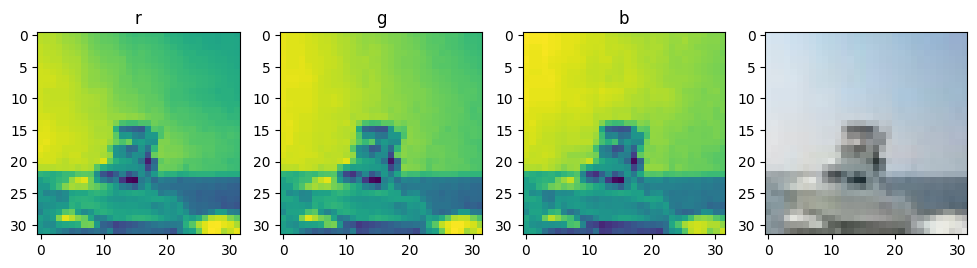

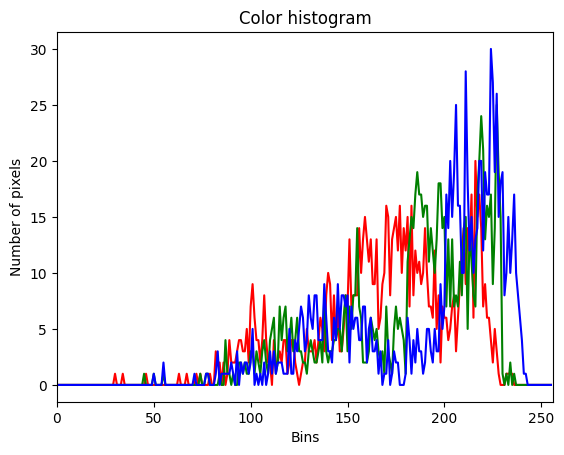

In [15]:
image_data = tf.keras.datasets.cifar10
(train_img, train_labels), (test_img, test_labels) = image_data.load_data()

colors=("r", "g", "b")

# this will read the image passed and return a 3-channel histogram of it
#path = r"test_images/lenna.png"
#path = r"test_images/rgb_test.png"
#path = r"test_images/rgb_test2.webp"
#colormap1 = cv2.imread(path) # stores images in BGR format
#colormap1=cv2.cvtColor(colormap1, cv2.COLOR_BGR2RGB)

image_index = 100
colormap1 = train_img[image_index] #choice(train_img)

chans=cv2.split(colormap1)

_, axs = plt.subplots(1, 4, figsize=(12, 12))
plt.imshow(colormap1)
axs = axs.flatten() # works but vscode marks as an error for some reason
i = 0
for img, ax in zip(chans, axs):
    ax.set_title(colors[i])
    ax.imshow(img)
    i += 1
plt.show()

plt.figure()
plt.title("Color histogram")
plt.xlabel("Bins")
plt.ylabel("Number of pixels")
for (chan, c) in zip(chans, colors):
    hist=cv2.calcHist([chan], [0], None, [256], [0,256])
    plt.plot(hist, color=c)
    plt.xlim([0,256])
plt.show()

In [16]:
# this will divide every image in the training set into their respective channels and store them

color_representations = [] # a tuple in the form (label, image, [channels])

print(f"Dividing {len(train_img)} images into channels...")
for i in range(len(train_img)):
    chans=cv2.split(train_img[i])
    color_representations.append((train_labels[i], train_img[i], chans))
    if i % 10000 == 0:
        print(f"{i} images divided")
print(f"{i+1} images divided, Done!")

Dividing 50000 images into channels...
0 images divided
10000 images divided
20000 images divided
30000 images divided
40000 images divided
49999 images divided, Done!


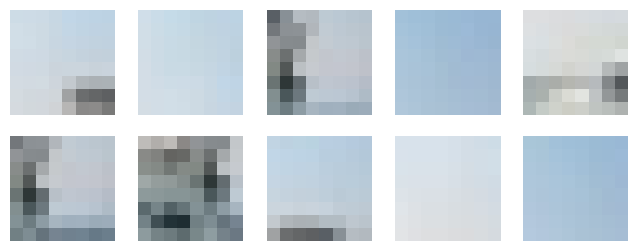

In [21]:
# returns a list of patches from the image passed
def get_patches(image, patch_size=8, n_patches=1000, random_state=10):
    patches = extract_patches_2d(image, patch_size=(patch_size, patch_size), max_patches=n_patches, random_state=10)
    return patches

# filling up the array with patches for each image
# also, both of these versions take the same amount of time to run :(

# version 1
patches_array = []
i = 0
for image in train_img:
    patches = get_patches(image)
    patches_array.append(patches)
    if i % 10000 == 0:
        print(f"{i} images patched")
    i += 1
print(f"{i} images patched, Done!")


# version 2
""" 
from joblib import Parallel, delayed
patches_array = Parallel(n_jobs=-1)(delayed(get_patches)(image) for image in train_img)
"""

# shows some of the patches
# the patches are taken from the image above
plt.figure(figsize=(8, 3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(patches_array[image_index][i])
    plt.axis("off")
